In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import joblib

In [7]:
STATION = 'VOI'
file_path = r"C:\Users\Admin\Desktop\PROJECT WORK\DROUGHT-FORECASTING-IN-KENYA-USING-MACHINE-LEARNING\Datafiles\WORKBOOKS\FINAL\SEASONAL.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')

print(f"Predicting drought for station: {STATION}")
print(f"Data shape: {df.shape}")

df = df.sort_values('YEAR')


Predicting drought for station: VOI
Data shape: (45, 12)



Data shape after feature engineering: (44, 26)

Finding the best model...

Evaluating GradientBoosting...
GradientBoosting Best RMSE: 1.1704
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_samples_split': 5, 'model__n_estimators': 100}
GradientBoosting R²: 0.5773

Evaluating RandomForest...
RandomForest Best RMSE: 1.0715
Best parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 200}
RandomForest R²: 0.7658

Evaluating SVR...
SVR Best RMSE: 0.9770
Best parameters: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
SVR R²: 0.0993

Evaluating NeuralNetwork...
NeuralNetwork Best RMSE: 1.6065
Best parameters: {'model__activation': 'tanh', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (50, 25)}
NeuralNetwork R²: 0.9938

Best model: NeuralNetwork with R² Score: 0.9938

Final Model Performance on Full Data:
R²: 0.9938
RMSE: 0.0752


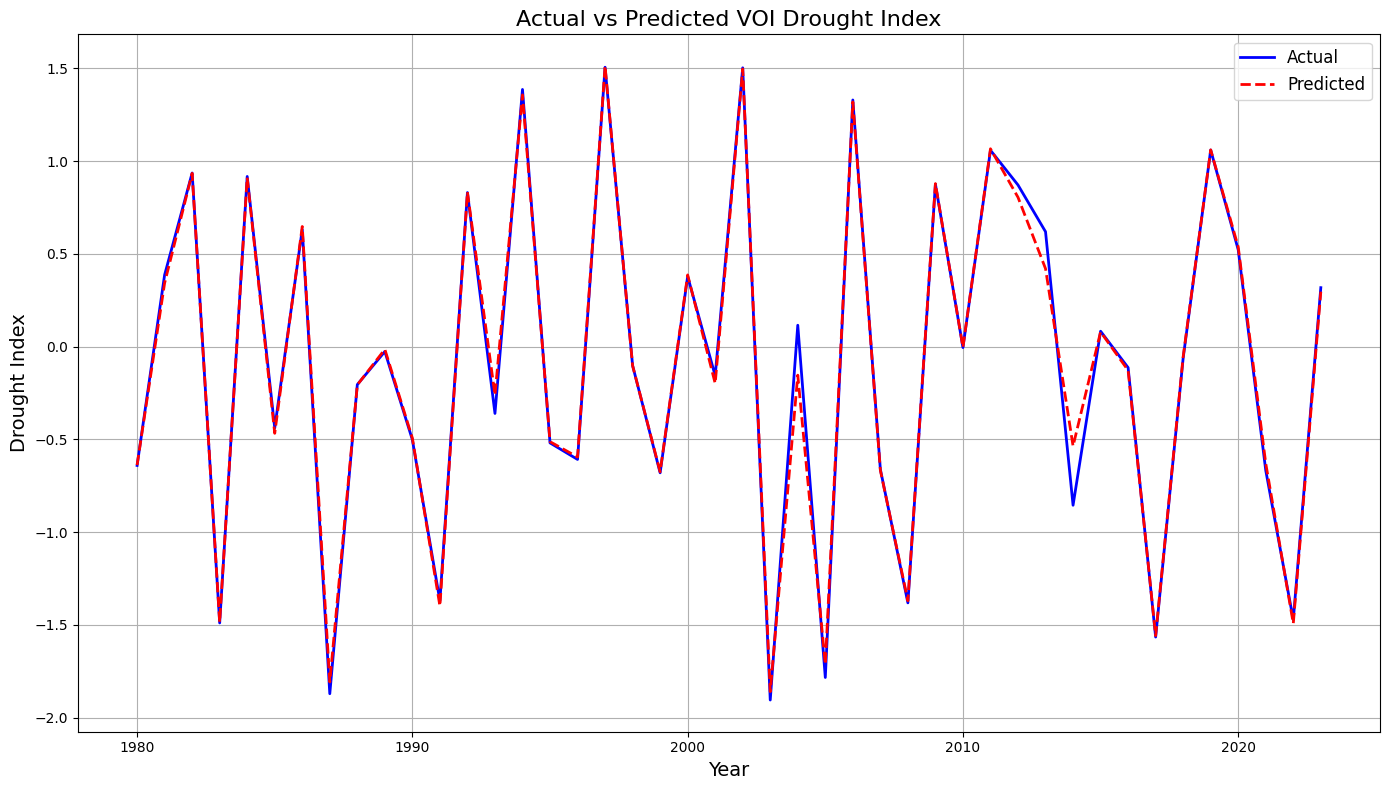


Years with highest prediction errors:
    Year    Actual  Predicted     Error  Abs_Error
35  2014 -0.855528  -0.536550 -0.318978   0.318978
25  2004  0.114925  -0.154196  0.269121   0.269121
34  2013  0.619067   0.419987  0.199080   0.199080
14  1993 -0.360620  -0.261621 -0.099000   0.099000
26  2005 -1.784015  -1.714109 -0.069907   0.069907

Example Prediction - El Niño conditions:

Predicted VOI drought index: 0.4717
Interpretation: Normal conditions

Example Prediction - La Niña conditions:

Predicted VOI drought index: 1.6151
Interpretation: Wet conditions (possible flooding)

Model saved as voi_drought_model_enhanced.pkl
Complete predictor saved as voi_drought_predictor.pkl


In [8]:
# Create interaction features and polynomial features
def engineer_features(dataframe, sst_columns):
    df_engineered = dataframe.copy()
    
    # Create interaction terms between SST indices
    for i, col1 in enumerate(sst_columns):
        for col2 in sst_columns[i:]:  # Avoid duplicates
            if col1 != col2:
                df_engineered[f'{col1}_{col2}_interact'] = df_engineered[col1] * df_engineered[col2]
    
    # Create lag features (previous year values)
    for col in sst_columns:
        df_engineered[f'{col}_lag1'] = df_engineered[col].shift(1)
    
    # Create squared terms to capture non-linear relationships
    for col in sst_columns:
        df_engineered[f'{col}_squared'] = df_engineered[col] ** 2
    
    # Drop rows with NaN values from lag creation
    df_engineered = df_engineered.dropna()
    
    return df_engineered

# Engineer features
sst_columns = ['IODW', 'IODE', 'NINO3.4', 'NINO4']
df_engineered = engineer_features(df, sst_columns)

print(f"\nData shape after feature engineering: {df_engineered.shape}")

# Get all feature columns (excluding the target and other station data)
feature_cols = [col for col in df_engineered.columns if col not in ['YEAR', STATION] + 
                [col for col in df_engineered.columns if col.startswith('GARISSA') or 
                                                      col.startswith('LAMU') or 
                                                      col.startswith('LODWAR') or 
                                                      col.startswith('MOMBASA') or 
                                                      col.startswith('MOYALE') or 
                                                      col.startswith('VOI') or
                                                      col.startswith('WAJIR')]]

# Prepare features and target
X = df_engineered[feature_cols]
y = df_engineered[STATION]

# Time series split for validation
tscv = TimeSeriesSplit(n_splits=5)

# Define advanced models
models = {
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', 'log2']
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf', 'poly']
        }
    },
    'NeuralNetwork': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 25)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01]
        }
    }
}

# Find best model through grid search
def find_best_model():
    best_score = -np.inf
    best_model_name = None
    best_grid = None
    
    for name, model_info in models.items():
        print(f"\nEvaluating {name}...")
        
        # Create pipeline with scaler
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model_info['model'])
        ])
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            pipeline,
            param_grid={'model__' + key: value for key, value in model_info['params'].items()},
            cv=tscv,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        
        grid_search.fit(X, y)
        
        # Get best score (MSE)
        best_mse = -grid_search.best_score_
        best_rmse = np.sqrt(best_mse)
        
        print(f"{name} Best RMSE: {best_rmse:.4f}")
        print(f"Best parameters: {grid_search.best_params_}")
        
        # Calculate R² on full data with the best model
        best_pipeline = grid_search.best_estimator_
        y_pred = best_pipeline.predict(X)
        r2 = r2_score(y, y_pred)
        
        print(f"{name} R²: {r2:.4f}")
        
        # Track best model
        if r2 > best_score:
            best_score = r2
            best_model_name = name
            best_grid = grid_search
    
    return best_model_name, best_grid.best_estimator_, best_score

# Find the best model
print("\nFinding the best model...")
best_model_name, best_pipeline, best_score = find_best_model()

print(f"\nBest model: {best_model_name} with R² Score: {best_score:.4f}")

# Final predictions on full data
y_pred = best_pipeline.predict(X)
final_r2 = r2_score(y, y_pred)
final_rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"\nFinal Model Performance on Full Data:")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(14, 8))
plt.plot(df_engineered['YEAR'], y, 'b-', linewidth=2, label='Actual')
plt.plot(df_engineered['YEAR'], y_pred, 'r--', linewidth=2, label='Predicted')
plt.title(f'Actual vs Predicted {STATION} Drought Index', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Drought Index', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{STATION}_prediction.png', dpi=300)
plt.show()

# Compute error metrics by year
error_df = pd.DataFrame({
    'Year': df_engineered['YEAR'],
    'Actual': y,
    'Predicted': y_pred,
    'Error': y - y_pred,
    'Abs_Error': abs(y - y_pred)
})

print("\nYears with highest prediction errors:")
print(error_df.sort_values('Abs_Error', ascending=False).head(5))

# Function for making predictions with new SST data
def predict_drought(iodw, iode, nino34, nino4, prev_iodw=None, prev_iode=None, prev_nino34=None, prev_nino4=None):
    # Create a dictionary to hold all our features
    input_data = {
        'IODW': iodw,
        'IODE': iode,
        'NINO3.4': nino34,
        'NINO4': nino4
    }
    
    # Add lag features if provided
    if all(x is not None for x in [prev_iodw, prev_iode, prev_nino34, prev_nino4]):
        input_data['IODW_lag1'] = prev_iodw
        input_data['IODE_lag1'] = prev_iode
        input_data['NINO3.4_lag1'] = prev_nino34
        input_data['NINO4_lag1'] = prev_nino4
    else:
        # Use means from training data as defaults
        for col in X.columns:
            if col.endswith('_lag1') and col not in input_data:
                base_col = col.replace('_lag1', '')
                input_data[col] = input_data.get(base_col, 0)
    
    # Create interaction and squared terms
    for i, col1 in enumerate(sst_columns):
        for col2 in sst_columns[i:]:
            if col1 != col2:
                input_data[f'{col1}_{col2}_interact'] = input_data[col1] * input_data[col2]
        
        # Create squared terms
        input_data[f'{col1}_squared'] = input_data[col1] ** 2
    
    # Create DataFrame with the right columns
    input_df = pd.DataFrame([input_data])
    
    # Ensure all required columns are present
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0  # Default value for missing columns
    
    # Reorder columns to match training data
    input_df = input_df[X.columns]
    
    # Make prediction
    prediction = best_pipeline.predict(input_df)[0]
    
    # Interpret prediction
    if prediction > 0.5:
        condition = "Wet conditions (possible flooding)"
    elif prediction < -0.5:
        condition = "Dry conditions (drought)"
    else:
        condition = "Normal conditions"
    
    print(f"\nPredicted {STATION} drought index: {prediction:.4f}")
    print(f"Interpretation: {condition}")
    
    return prediction

# Example predictions
print("\nExample Prediction - El Niño conditions:")
predict_drought(0.5, 0.1, 2.0, 1.0, 0.3, 0.0, 1.5, 0.8)

print("\nExample Prediction - La Niña conditions:")
predict_drought(-0.5, -0.3, -1.5, -0.8, -0.4, -0.2, -1.0, -0.6)

model_filename = f"{STATION.lower()}_drought_model_enhanced.pkl"
joblib.dump(best_pipeline, model_filename)
print(f"\nModel saved as {model_filename}")

class DroughtPredictor:
    def __init__(self, pipeline, feature_columns, sst_columns):
        self.pipeline = pipeline
        self.feature_columns = feature_columns
        self.sst_columns = sst_columns
        
    def predict(self, iodw, iode, nino34, nino4, prev_iodw=None, prev_iode=None, prev_nino34=None, prev_nino4=None):
        # Create a dictionary to hold all our features
        input_data = {
            'IODW': iodw,
            'IODE': iode,
            'NINO3.4': nino34,
            'NINO4': nino4
        }
        
        if all(x is not None for x in [prev_iodw, prev_iode, prev_nino34, prev_nino4]):
            input_data['IODW_lag1'] = prev_iodw
            input_data['IODE_lag1'] = prev_iode
            input_data['NINO3.4_lag1'] = prev_nino34
            input_data['NINO4_lag1'] = prev_nino4
        else:
            # Use current values as defaults
            input_data['IODW_lag1'] = input_data['IODW']
            input_data['IODE_lag1'] = input_data['IODE']
            input_data['NINO3.4_lag1'] = input_data['NINO3.4']
            input_data['NINO4_lag1'] = input_data['NINO4']
        
        # Create interaction and squared terms
        for i, col1 in enumerate(self.sst_columns):
            for col2 in self.sst_columns[i:]:
                if col1 != col2:
                    input_data[f'{col1}_{col2}_interact'] = input_data[col1] * input_data[col2]
            
            # Create squared terms
            input_data[f'{col1}_squared'] = input_data[col1] ** 2
        
        # Create DataFrame with the right columns
        input_df = pd.DataFrame([input_data])
        
        # Ensure all required columns are present
        for col in self.feature_columns:
            if col not in input_df.columns:
                input_df[col] = 0  # Default value for missing columns
        
        # Reorder columns to match training data
        input_df = input_df[self.feature_columns]
        
        # Make prediction
        prediction = self.pipeline.predict(input_df)[0]
        
        return prediction

# Create and save the predictor
predictor = DroughtPredictor(best_pipeline, X.columns, sst_columns)
predictor_filename = f"{STATION.lower()}_drought_predictor.pkl"
joblib.dump(predictor, predictor_filename)
print(f"Complete predictor saved as {predictor_filename}")